# 0 - Presentation

This notebook contains the full code used to generate the figures for our article  
*“Analysis and Discussion on Over-Squashing in Message Passing Neural Networks:  
The Impact of Width, Depth, and Topology.”*

The document is structured as follows:
- **Part 1** generates the dataset,  
- **Part 2** defines the model,  
- **Part 3** presents and visualizes the results.  

The main contribution of our article appears in subsection **3.3 Star Graph Experiment**.


# 1- Dataset generator

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
import torch

class SyntheticSignalGenerator:
    def __init__(
        self,
        Fe=1.0,
        N=100,
        nb_signaux=1000,
        nb_cos=2,
        cos_params_range=None,
        nb_poly=0,
        poly_degree=2,
        noise_std=0.0,
        test_size=0.2,
        random_state=None
    ):
        
        """
        Synthetic signal generator with seasonality, trend, and noise.

        Arguments :
        - Fe : sampling frequency
        - N : length of the signals
        - nb_signaux : total number of signals to generate
        - nb_cos : number of cosine components per signal
        - cos_params_range : dictionary with ranges {'A': (min,max), 'f': (min,max), 'phi': (min,max)}
        - nb_poly : number of signals with polynomial trend to generate (among nb_signaux)
        - poly_degree : degree of the polynomial for the trend
        - noise_std : standard deviation of Gaussian noise
        - test_size : fraction of the dataset reserved for validation
        - random_state : random seed for reproducibility
        """
        self.Fe = Fe
        self.N = N
        self.nb_signaux = nb_signaux
        self.nb_cos = nb_cos
        self.nb_poly = nb_poly
        self.poly_degree = poly_degree
        self.noise_std = noise_std
        self.test_size = test_size
        self.random_state = random_state

        # Define cosine parameter ranges if not specified
        self.cos_params_range = cos_params_range or {
            'A': (0.5, 3.5),
            'f': (0.1, 1),
            'phi': (0, 2 * np.pi)
        }

        self.scaler = MinMaxScaler()
        self.time = np.arange(self.N) / self.Fe

    def _generate_single_signal(self, use_poly=False):
        signal = np.zeros_like(self.time)
        
        # Add cosine components
        for _ in range(self.nb_cos):
            A = np.random.uniform(*self.cos_params_range['A'])
            f = np.random.uniform(*self.cos_params_range['f'])
            phi = np.random.uniform(*self.cos_params_range['phi'])
            signal += A * np.cos(2 * np.pi * f * self.time + phi)

        # Add polynomial trend if requested
        if use_poly:
            coeffs = np.random.uniform(-1, 1, size=(self.poly_degree + 1,))
            trend = np.polyval(coeffs, self.time / self.time[-1])  # normalize time
            signal += trend

        # Add noise
        signal += np.random.normal(0, self.noise_std, size=self.N)
        return signal

    def generate_dataset(self):
        X = []
        for i in range(self.nb_signaux):
            use_poly = (i < self.nb_poly)
            signal = self._generate_single_signal(use_poly)
            X.append(signal)

        X = np.array(X)

        # Split train/val
        X_train, X_val = train_test_split(X, test_size=self.test_size, random_state=self.random_state)

        # Fit scaler sur le train
        self.scaler.fit(X_train)

        # Normalize
        X_train_norm = self.scaler.transform(X_train)
        X_val_norm = self.scaler.transform(X_val)

        return {
            'train_raw': X_train,
            'val_raw': X_val,
            'train_scaled': X_train_norm,
            'val_scaled': X_val_norm,
            'scaler': self.scaler
        }


In [16]:
import matplotlib.pyplot as plt

def plot_signals(dataset, Fe=1.0, n=5):
    """
    Affiche les n premiers signaux (raw et normalisés) du dataset généré.

    Arguments :
    - dataset : dictionnaire renvoyé par generate_dataset()
    - Fe : fréquence d’échantillonnage pour l’axe temporel
    - n : nombre de signaux à afficher
    """
    time = np.arange(dataset['train_raw'].shape[1]) / Fe

    fig, axes = plt.subplots(n, 2, figsize=(12, 2.5 * n), sharex=True)
    if n == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(n):
        axes[i, 0].plot(time, dataset['train_raw'][i], label='Signal brut')
        axes[i, 0].set_title(f'Signal #{i+1} (brut)')
        axes[i, 0].grid(True)

        axes[i, 1].plot(time, dataset['train_scaled'][i], label='Signal normalisé', color='orange')
        axes[i, 1].set_title(f'Signal #{i+1} (normalisé)')
        axes[i, 1].grid(True)

    axes[-1, 0].set_xlabel('Temps (s)')
    axes[-1, 1].set_xlabel('Temps (s)')
    plt.tight_layout()
    plt.show()


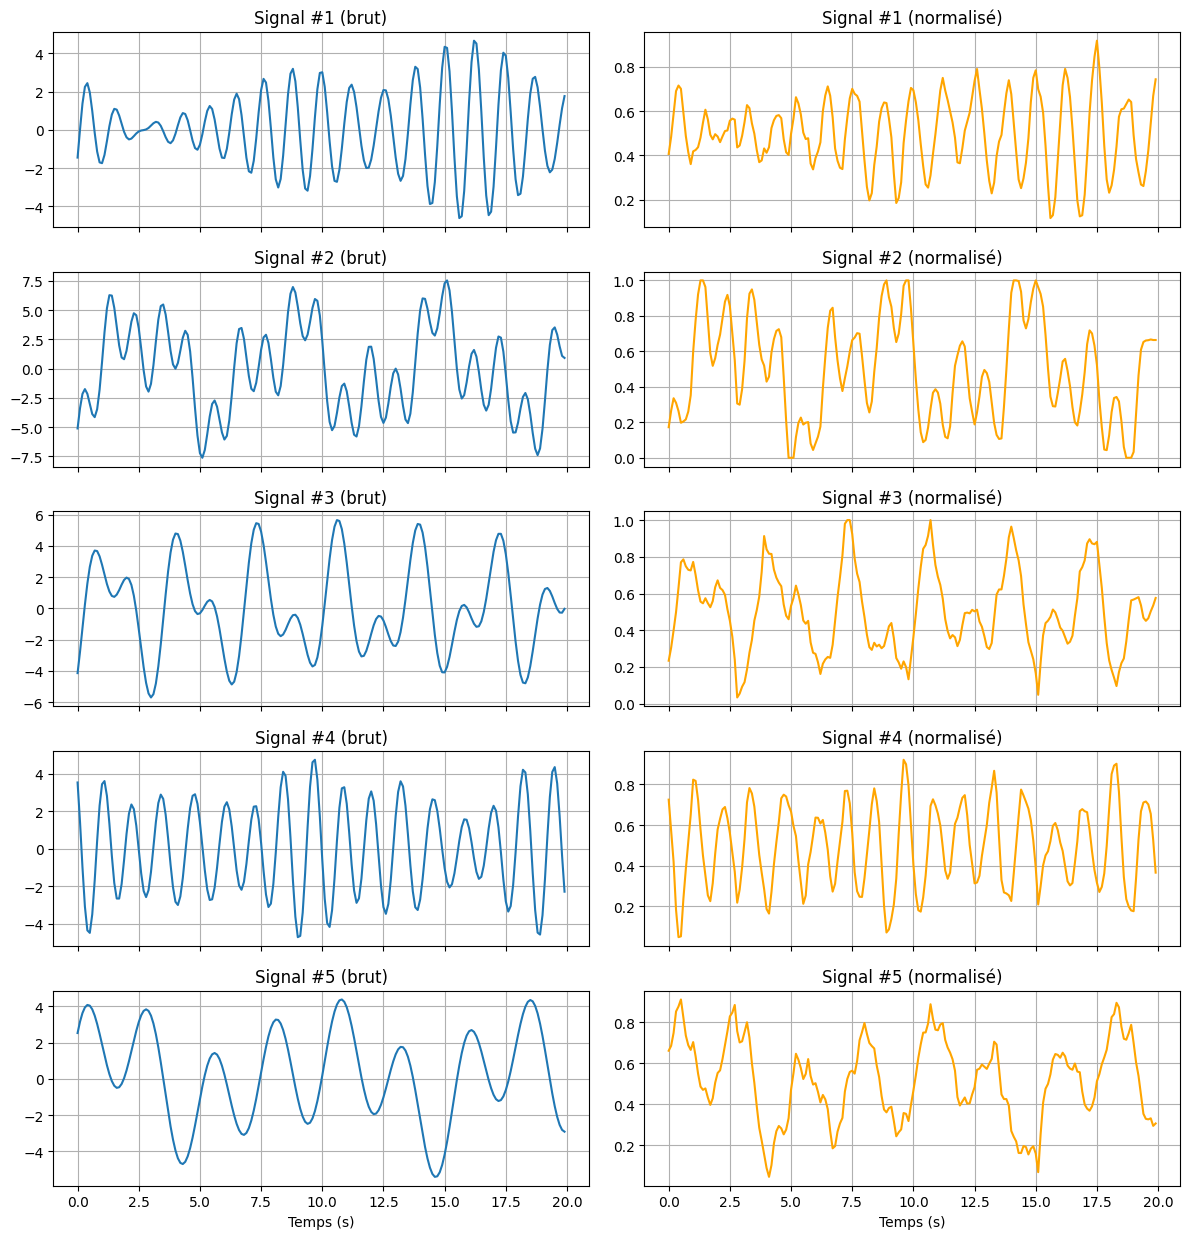

In [ ]:
# After generating your dataset:
generator = SyntheticSignalGenerator(Fe=10, N=200, nb_signaux=100, nb_cos=3, nb_poly=0, poly_degree=3, noise_std=0)
dataset = generator.generate_dataset()

# Visualization
plot_signals(dataset, Fe=10, n=5)


In [ ]:
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse

class GraphDatasetBuilder:
    def __init__(
        self,
        num_nodes,
        n_signals_per_node,
        source_nodes,
        target_nodes,
        adj_matrix,
        Fe=10,
        N=200,
        nb_cos=3,
        cos_params_range=None,
        nb_poly=0,
        poly_degree=2,
        noise_std=0.0,
        test_size=0.2,
        random_state=None,
        encoder_layers=2,
        decoder_layers=2,
        latent_dim=32,
        hidden_dim=64,
        gat_layers=1,
        heads=1
    ):
        """
        Central class that generates the dataset and the compatible model.

        Data:
        - Generates nb_signaux = len(source_node) * n_signals_per_node
        - Injects signals into the source_nodes
        - Expects reconstructions from the target_nodes
        """
        self.num_nodes = num_nodes
        self.n_signals_per_node = n_signals_per_node
        assert len(source_nodes) == len(target_nodes), "Each source must have an associated target"
        self.nb_signaux = len(source_nodes) * n_signals_per_node

        self.source_nodes = source_nodes
        self.target_nodes = target_nodes
        self.adj_matrix = adj_matrix
        self.edge_index, self.edge_weights = self.adj_to_edge_index_and_weight(self.adj_matrix)

        self.Fe = Fe
        self.N = N
        self.nb_cos = nb_cos
        self.cos_params_range = cos_params_range
        self.nb_poly = nb_poly
        self.poly_degree = poly_degree
        self.noise_std = noise_std
        self.test_size = test_size
        self.random_state = random_state

        # to build the model later
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.gat_layers = gat_layers
        self.heads = heads

    def build(self):
        # Create the signal generator with the correct parameters
        self.generator = SyntheticSignalGenerator(
            Fe=self.Fe,
            N=self.N,
            nb_signaux=self.nb_signaux,
            nb_cos=self.nb_cos,
            cos_params_range=self.cos_params_range,
            nb_poly=self.nb_poly,
            poly_degree=self.poly_degree,
            noise_std=self.noise_std,
            test_size=self.test_size,
            random_state=self.random_state
        )

        # Generate and structure
        raw_data = self.generator.generate_dataset()
        X_train_raw = raw_data['train_raw']
        X_train_scaled = raw_data['train_scaled']
        X_val_raw = raw_data['val_raw']
        X_val_scaled = raw_data['val_scaled']
        self.scaler = raw_data['scaler']

        def structure(X_raw, X_scaled):
            data = []

            # We assume we have len(source_nodes) * n_signals_per_node signals
            for j in range(int(X_raw.shape[0]//len(self.source_nodes))-1):  # one graph per sample
                # Initialize x and y to zero
                x = torch.zeros((self.num_nodes, self.N), dtype=torch.float32)
                y = torch.zeros((self.num_nodes, self.N), dtype=torch.float32)
                target_mask = torch.zeros(self.num_nodes, dtype=torch.bool)

                for i, src in enumerate(self.source_nodes):
                    tgt = self.target_nodes[i]
                    idx = i * len(self.source_nodes) + j  # correct index in X_raw/scaled

                    # Inject the signal of each source into its own node
                    x[src] = torch.tensor(X_scaled[idx], dtype=torch.float32)

                    # Target to reconstruct: each target receives the raw signal
                    y[tgt] = torch.tensor(X_raw[idx], dtype=torch.float32)
                    target_mask[tgt] = True

                # Group all information for one graph
                sample = Data(
                    x=x,
                    y=y,
                    edge_index=self.edge_index,
                    edge_weight=self.edge_weights,
                    source_nodes=torch.tensor(self.source_nodes, dtype=torch.long),
                    target_mask=target_mask,
                    num_nodes=self.num_nodes
                )
                data.append(sample)

            return data



        self.train_data = structure(X_train_raw, X_train_scaled)
        self.val_data = structure(X_val_raw, X_val_scaled)

        return {
            'train': self.train_data,
            'val': self.val_data,
            'scaler': self.scaler
        }


    def adj_to_edge_index_and_weight(self, adj_matrix):
        """
        Convert an adjacency matrix (torch.Tensor) to edge_index and edge_weight for PyTorch Geometric.
        
        Input:
        - adj_matrix : (N, N), adjacency matrix (dense or sparse COO) with weights (0 = no edge)

        Output:
        - edge_index : (2, E) LongTensor
        - edge_weight : (E,) FloatTensor
        """
        if not torch.is_tensor(adj_matrix):
            adj_matrix = torch.tensor(adj_matrix, dtype=torch.float)

        if adj_matrix.is_sparse:
            edge_index = adj_matrix.coalesce().indices()
            edge_weight = adj_matrix.coalesce().values()
        else:
            edge_index, edge_weight = dense_to_sparse(adj_matrix)

        return edge_index.long(), edge_weight.float()


    def build_model(self, model_cls, use_edge_weight: bool = False, signed: bool = False):
        """
        Instantiate a GraphAutoPropagator (or any compatible class) with the
        standard hyperparameters plus the two flags:
          - use_edge_weight: whether to pass edge_weight to forward()
          - signed: whether to append node‐ID as extra feature
        """
        model = model_cls(
            input_dim       = self.N,
            latent_dim      = self.latent_dim,
            hidden_dim      = self.hidden_dim,
            encoder_layers  = self.encoder_layers,
            decoder_layers  = self.decoder_layers,
            gat_layers      = self.gat_layers,
            heads           = self.heads,
            use_edge_weight = use_edge_weight,
            signed          = signed,
        )
        return model

    def to_pyg_dataset(self, split='train'):
        """
        Return the list of pre-constructed PyG Data objects with (x, y, edge_index, etc...)
        """
        assert split in ['train', 'val']
        return getattr(self, f"{split}_data")








# 2-Creating the model 

In [23]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATv2Conv, DeepGCNLayer

class GraphAutoPropagator(nn.Module):
    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 hidden_dim: int = 64,
                 encoder_layers: int = 2,
                 decoder_layers: int = 2,
                 gat_layers: int = 1,
                 heads: int = 1,
                 use_edge_weight: bool = False,
                 signed: bool = False,
                ):
        super().__init__()
        self.heads = heads
        self.use_edge_weight = use_edge_weight
        self.signed = signed

        # --- Encoder ---
        encoder = []
        dx = hidden_dim - input_dim
        dt = max(encoder_layers - 1, 1)
        for i in range(encoder_layers - 1):
            in_dim  = int(input_dim + dx / dt * i)
            out_dim = int(input_dim + dx / dt * (i + 1))
            encoder += [nn.Linear(in_dim, out_dim), nn.GELU()]
        encoder += [nn.Linear(out_dim, latent_dim)]
        self.encoder = nn.Sequential(*encoder)

        # --- GAT propagation ---
        self.gat_layers = nn.ModuleList()
        for _ in range(gat_layers):
            in_dim = latent_dim + (1 if signed else 0)
            conv_kwargs = dict(
                in_channels=in_dim,
                out_channels=latent_dim + (1 if signed else 0),
                heads=heads,
                concat=False,
                add_self_loops=False
            )
            if use_edge_weight:
                conv_kwargs['edge_dim'] = 1

            conv = GATv2Conv(**conv_kwargs)
            norm = nn.LayerNorm(conv_kwargs['out_channels'])
            act  = nn.ReLU(inplace=True)
            layer = DeepGCNLayer(conv=conv, norm=norm, act=act,
                                 block='res+', ckpt_grad=True)
            self.gat_layers.append(layer)

        # --- Decoder ---
        decoder = []
        dx = input_dim - hidden_dim
        dt = max(decoder_layers - 1, 1)
        # first decoder layer takes whatever final GAT dim is:
        first_dim = latent_dim + (1 if signed else 0)
        decoder += [nn.Linear(first_dim, hidden_dim), nn.GELU()]
        for i in range(decoder_layers - 1):
            in_dim  = int(hidden_dim + dx / dt * i)
            out_dim = int(hidden_dim + dx / dt * (i + 1))
            decoder += [nn.Linear(in_dim, out_dim), nn.GELU()]
        decoder += [nn.Linear(out_dim, input_dim)]
        self.decoder = nn.Sequential(*decoder)


    def forward(self,
                x: torch.Tensor,
                edge_index: torch.LongTensor,
                source_nodes: torch.LongTensor,
                target_mask: torch.BoolTensor,
                num_nodes_per_graph: int,
                edge_weight: torch.Tensor = None
               ) -> torch.Tensor:
        # x: (B*N, input_dim)
        device = x.device
        batch_size = x.size(0) // num_nodes_per_graph
        in_dim = x.size(1)

        # reshape to (B, N, input_dim)
        x_batched = x.view(batch_size, num_nodes_per_graph, in_dim)
        # select source embeddings
        xs = x_batched[:, source_nodes, :].reshape(-1, in_dim)
        # encode
        zs = self.encoder(xs)  # (B * #sources, latent_dim)
        latent_dim = zs.size(1)

        # build 3D tensor for propagation
        gat_dim = latent_dim + (1 if self.signed else 0)
        z = torch.zeros(batch_size, num_nodes_per_graph, gat_dim, device=device)
        # fill in encoded source slots
        z[:, source_nodes, :latent_dim] = zs.view(batch_size, -1, latent_dim)
        # optionally append a node‐id scalar for signed variant
        if self.signed:
            ids = torch.arange(num_nodes_per_graph, device=device).unsqueeze(0)
            ids = ids.repeat(batch_size, 1) / num_nodes_per_graph
            z[:, :, -1] = ids

        # flatten for GAT: (B*N, gat_dim)
        z_flat = z.view(-1, gat_dim)

        # propagate
        for layer in self.gat_layers:
            if self.use_edge_weight and edge_weight is not None:
                z_flat = layer(z_flat, edge_index, edge_weight)
            else:
                z_flat = layer(z_flat, edge_index)

        # select target nodes and decode
        z_t = z_flat[target_mask]
        return self.decoder(z_t)


In [ ]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class GraphTrainer:
    def __init__(self, model, saving_directory, device='cpu', patience=100):
        self.model     = model.to(device)
        self.saving_directory = saving_directory
        self.device    = device
        self.history   = {'train_loss': [], 'val_loss': []}
        self.best_val_loss = float('inf')
        self.patience  = patience

        os.makedirs(self.saving_directory, exist_ok=True)
        self.model_path = os.path.join(self.saving_directory, 'best_model.pt')

        # load if exists
        if os.path.exists(self.model_path):
            self.model.load_state_dict(torch.load(self.model_path, map_location=device))
            print(f"📦 Loaded model from {self.model_path}")

    def train(self, train_loader, val_loader, num_nodes, epochs=200, lr=1e-3, verbose=True):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        loss_fn   = nn.MSELoss()
        num_nodes = torch.tensor(num_nodes, device=self.device)
        best_epoch = 0

        for epoch in range(1, epochs+1):
            self.model.train()
            total_train = 0.0

            for batch in train_loader:
                batch = batch.to(self.device)
                optimizer.zero_grad()

                # decide whether to pass edge_weight
                if self.model.use_edge_weight:
                    y_pred = self.model(batch.x,
                                        batch.edge_index,
                                        batch.source_nodes,
                                        batch.target_mask,
                                        num_nodes,
                                        batch.edge_weight)
                else:
                    y_pred = self.model(batch.x,
                                        batch.edge_index,
                                        batch.source_nodes,
                                        batch.target_mask,
                                        num_nodes)
                loss = loss_fn(y_pred, batch.y[batch.target_mask])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5.0)
                optimizer.step()
                total_train += loss.item()

            train_loss = total_train / len(train_loader)
            self.history['train_loss'].append(train_loss)

            # validation
            val_loss = self.evaluate(val_loader, num_nodes, loss_fn, silent=True, plot=False)
            self.history['val_loss'].append(val_loss)

            # checkpoint
            if val_loss < self.best_val_loss:
                os.makedirs(os.path.dirname(self.model_path), exist_ok=True)
                torch.save(self.model.state_dict(), self.model_path)
                self.best_val_loss = val_loss
                best_epoch = epoch
                if verbose:
                    print(f"--- New best model (val_loss={val_loss:.4f})")

            # logging
            if verbose and epoch % 3 == 0:
                print(f"[Epoch {epoch}] Train: {train_loss:.4f} | Val: {val_loss:.4f}")
            if verbose and epoch % 30 == 0:
                self._plot_history()

            # early stopping
            if epoch - best_epoch >= self.patience:
                print("⏹ Early stopping")
                break

    def evaluate(self, loader, num_nodes, loss_fn=None, silent=False, plot=True):
        self.model.eval()
        loss_fn = loss_fn or nn.MSELoss()
        num_nodes = torch.tensor(num_nodes, device=self.device)
        total_val = 0.0

        with torch.no_grad():
            for batch_idx, batch in enumerate(loader):
                batch = batch.to(self.device)
                if self.model.use_edge_weight:
                    y_pred = self.model(batch.x,
                                        batch.edge_index,
                                        batch.source_nodes,
                                        batch.target_mask,
                                        num_nodes,
                                        batch.edge_weight)
                else:
                    y_pred = self.model(batch.x,
                                        batch.edge_index,
                                        batch.source_nodes,
                                        batch.target_mask,
                                        num_nodes)

                loss = loss_fn(y_pred, batch.y[batch.target_mask])
                total_val += loss.item()

                if plot and batch_idx == 0:
                    y_true = batch.y[batch.target_mask].cpu()
                    y_hat  = y_pred.cpu()
                    # find which indices are true targets within one graph
                    # num_nodes is scalar tensor
                    N = num_nodes.item()
                    mask = batch.target_mask.view(-1, N)[0]  # first graph mask
                    target_indices = mask.nonzero(as_tuple=False).flatten().tolist()

                    fig, axs = plt.subplots(len(target_indices), 1, figsize=(8, 2.5*len(target_indices)))
                    if len(target_indices)==1: axs=[axs]
                    for i,(ti,ax) in enumerate(zip(target_indices, axs)):
                        ax.plot(y_true[i], label='True')
                        ax.plot(y_hat[i], label='Pred')
                        # ajouter des borne en y pour mieux voir
                        ax.set_ylim([-6.5, 6.5])
                        ax.set_title(f'Node target {i}')
                        ax.legend()
                    plt.tight_layout()
                    plt.show()

        avg_val = total_val / len(loader)
        if not silent:
            print(f"📊 Eval Loss: {avg_val:.4f}")
        return avg_val

    def _plot_history(self):
        plt.figure(figsize=(8,4))
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'],   label='Val Loss')
        plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
        plt.legend(); plt.grid(True)
        plt.title('Training History')
        plt.tight_layout()
        plt.show()


In [25]:
def plot_rmse_experiment(losses, x, title="Impact de la longueur de chaîne sur la reconstruction", xlabel = " nombre de couple source target", save_path=None):
    """
    Affiche joliment la courbe RMSE en fonction de la longueur de la chaîne.
    
    Args:
        losses (list of float): Liste des pertes RMSE, où l'élément i correspond à une chaîne de longueur i.
        title (str): Titre du graphique.
        save_path (str, optional): Si fourni, enregistre la figure à ce chemin.
    """
    chain_lengths = x
    #np.arange(len(losses))
    plt.figure(figsize=(8, 5))
    plt.plot(chain_lengths, losses, marker='o', linestyle='-', linewidth=2)
    plt.plot([chain_lengths[0], chain_lengths[-1]], [2.68**2, 2.68**2], linestyle='--', color='red', label = 'std of signals')
    plt.xlabel(xlabel=xlabel, fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    plt.legend()
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xticks(chain_lengths)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

In [26]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

def run_experiments(
    experiments,
    graph_builder,
    builder_cls,
    model_cls,
    trainer_cls,
    base_saving_dir = 'default',
    train=True,
    train_params=None,
    builder_common_kwargs=None,
    model_common_kwargs=None,
    device= 'cuda',
    plot=True, 
    title = 'GAT performance vs. graph size', 
    xlabel = 'number of nodes',
):
    """
    experiments: list of dicts, each has
        - num_nodes (int)
        - source_nodes (list[int])
        - target_nodes (list[int])
        - graph_kwargs (dict)  # extra args to graph_builder
    graph_builder: fn(num_nodes, **graph_kwargs) -> adj_matrix (torch.Tensor)
    builder_cls:      GraphDatasetBuilder
    model_cls:        GraphAutoPropagator (or compatible)
    trainer_cls:      GraphTrainer
    train:            bool — whether to train or only eval
    train_params:     dict passed to trainer.train(...)
    builder_common_kwargs: dict of builder args common to all experiments
    model_common_kwargs:   dict of model args common to all exps
    device:           'cpu' or 'cuda'
    plot:             whether to plot results at end
    """
    train_params = train_params or {}
    builder_common_kwargs = builder_common_kwargs or {}
    model_common_kwargs   = model_common_kwargs   or {}

    results = []
    x = []
    Llosses = []
    for exp in experiments:
        num_nodes   = exp['num_nodes']
        N     = exp['N']
        src   = exp['source_nodes']
        tgt   = exp['target_nodes']
        builder_common_kwargs['gat_layers'] = exp.get('gat_layers', builder_common_kwargs['gat_layers'])
        gkw   = exp.get('graph_kwargs', {})

        
        # 1) build adjacency
        adj = graph_builder(num_nodes, **gkw)
        print (f'adj_matrix {adj}')
        # 2) build dataset
        builder = builder_cls(
            num_nodes=num_nodes,
            source_nodes=src,
            target_nodes=tgt,
            adj_matrix=adj,
            **builder_common_kwargs
        )
        data = builder.build()
        batch_size = train_params.get('batch_size', 64)
        # pop de batch_size dans train_params si présent
        if 'batch_size' in train_params:
            train_params.pop('batch_size')
        # Construire les datasets PyG
        train_loader = DataLoader(builder.to_pyg_dataset('train'), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(builder.to_pyg_dataset('val'), batch_size=128*2)

        # 3) instantiate model
        model = builder.build_model(
            model_cls,
            **model_common_kwargs
        )
        trainer = trainer_cls(
            model,
            saving_directory=os.path.join(base_saving_dir, f"exp_N{N}"),
            device=device
        )
        # 4) optionally train
        if train:
            trainer.train(train_loader, val_loader, num_nodes=num_nodes, **train_params)

        # 5) evaluate
        val_loss = trainer.evaluate(val_loader, num_nodes=num_nodes, silent=True, plot=plot)
        results.append({'N':N, 'val_loss':val_loss})
    for dic  in results : 
        x.append(dic['N'])
        Llosses.append(dic['val_loss'])
    # 6) plot
    if plot:
        Ns   = [r['N'] for r in results]
        loss = [r['val_loss'] for r in results]
        plt.figure(figsize=(6,4))
        plt.plot(Ns, loss, marker='o')
        plt.xlabel(xlabel)
        plt.ylabel('Validation RMSE')
        plt.title(title)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plot_rmse_experiment(Llosses, x, title=title , xlabel = xlabel, save_path=None)
        

    return results


# 3-Experiment 

## 3.1- Chain

Chain adjacency (1 nodes):
 tensor([[1.]])
adj_matrix tensor([[1.]])
📦 Loaded model from chain\exp_N1\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

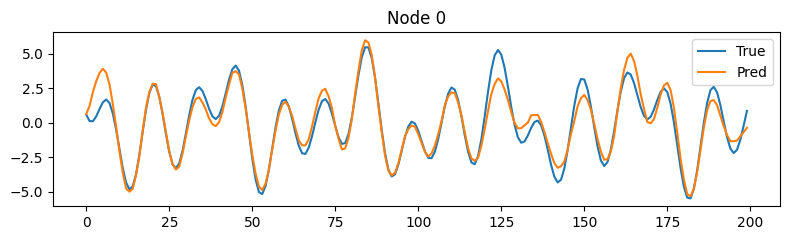

Chain adjacency (2 nodes):
 tensor([[1., 1.],
        [1., 1.]])
adj_matrix tensor([[1., 1.],
        [1., 1.]])
📦 Loaded model from chain\exp_N2\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

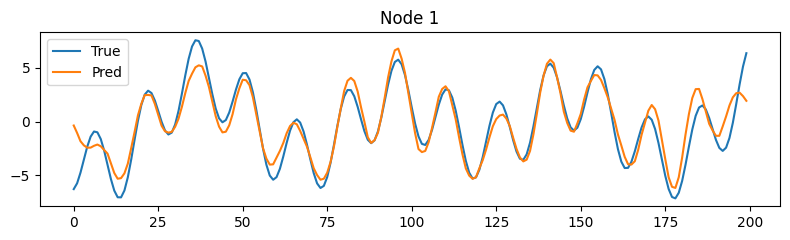

Chain adjacency (3 nodes):
 tensor([[1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.]])
adj_matrix tensor([[1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.]])
📦 Loaded model from chain\exp_N3\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

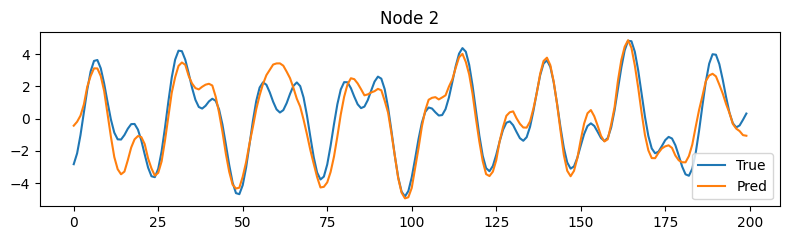

Chain adjacency (4 nodes):
 tensor([[1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.]])
adj_matrix tensor([[1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.]])
📦 Loaded model from chain\exp_N4\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

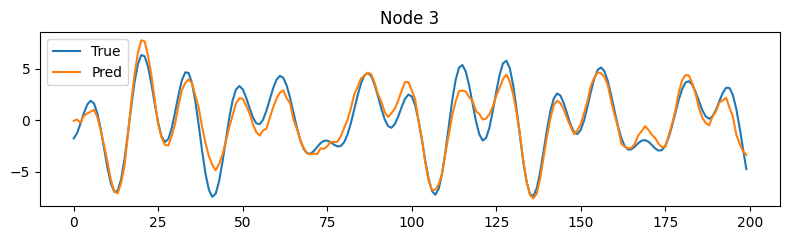

Chain adjacency (5 nodes):
 tensor([[1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.]])
adj_matrix tensor([[1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.]])
📦 Loaded model from chain\exp_N5\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

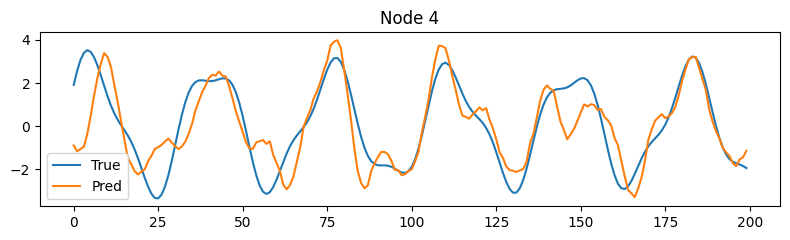

Chain adjacency (6 nodes):
 tensor([[1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.]])
adj_matrix tensor([[1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.]])


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

📦 Loaded model from chain\exp_N6\best_model.pt


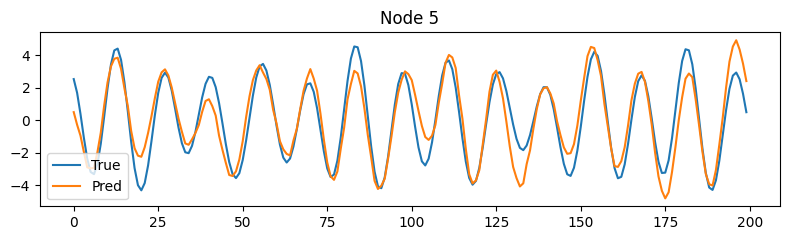

Chain adjacency (7 nodes):
 tensor([[1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1.]])
adj_matrix tensor([[1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1.]])
📦 Loaded model from chain\exp_N7\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

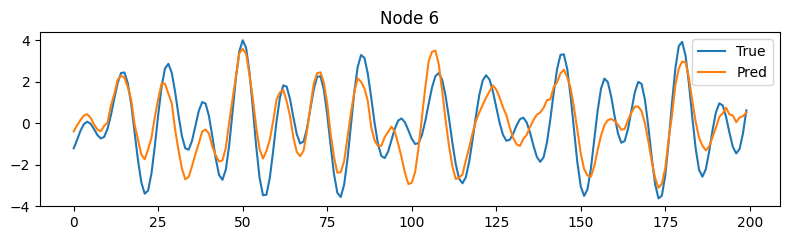

Chain adjacency (8 nodes):
 tensor([[1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1.]])
adj_matrix tensor([[1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1.]])
📦 Loaded model from chain\exp_N8\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

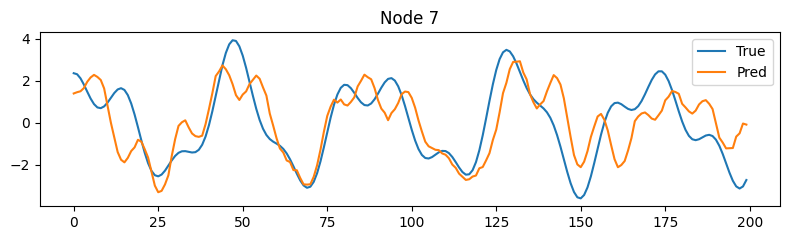

Chain adjacency (9 nodes):
 tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])
adj_matrix tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1.]])
📦 Loaded model from chain\exp_N9\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

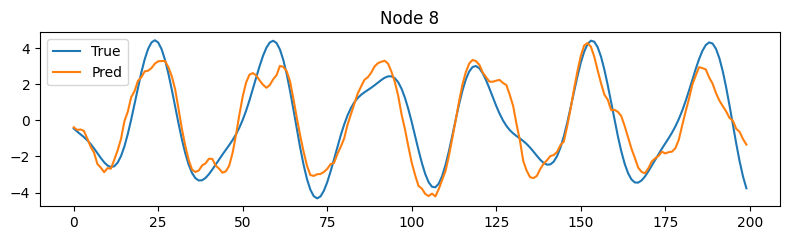

Chain adjacency (10 nodes):
 tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])
adj_matrix tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [

C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

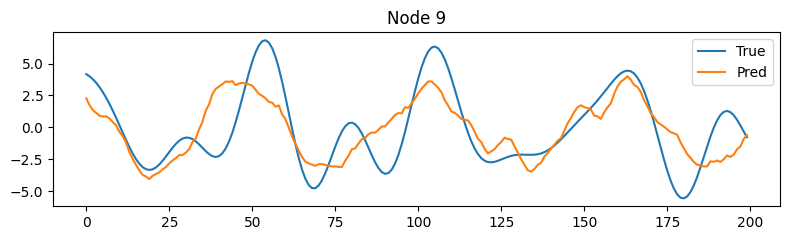

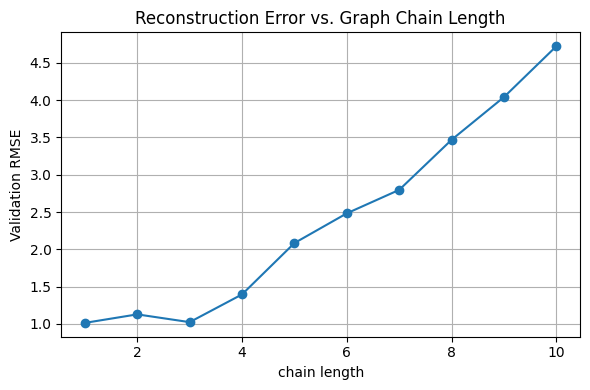

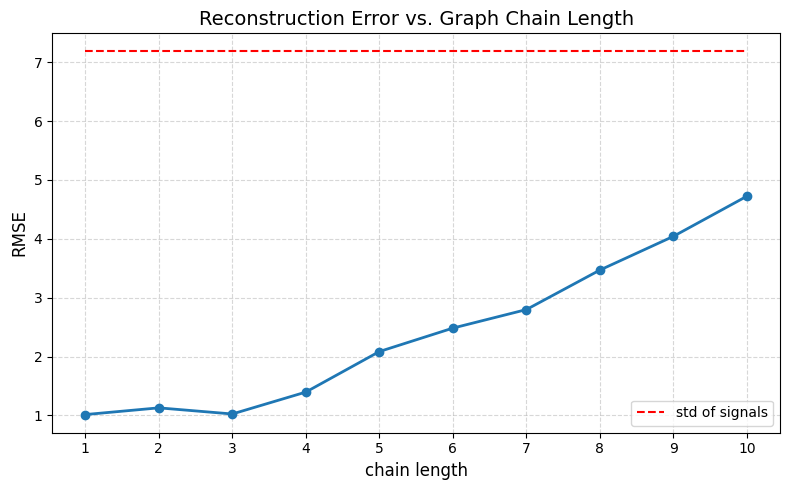

In [13]:
# simple chain-graph builder
def chain_graph(num_nodes):
    
    adj = torch.zeros((num_nodes, num_nodes))
    for j in range(1, num_nodes):
        adj[j-1, j] = 1
        
    adj = adj + adj.T
    for j in range(num_nodes) :
        adj[j, j] = 1
    print(f"Chain adjacency ({num_nodes} nodes):\n", adj)
    return adj

exps = [
    {'num_nodes': n, 'N' : n,  'source_nodes':[0], 'target_nodes':[n-1], 'gat_layers' : n}
    for n in range(1, 11)
]

results = run_experiments(
    experiments=exps,
    graph_builder=chain_graph,
    builder_cls=GraphDatasetBuilder,
    model_cls=GraphAutoPropagator,
    trainer_cls=GraphTrainer,
    base_saving_dir = 'chain',
    train=False,
    train_params={'epochs':40, 'lr':1e-3, 'batch_size':256},
    builder_common_kwargs={
        'n_signals_per_node':5000,
        'N':200,
        'encoder_layers':2,
        'decoder_layers':2,
        'latent_dim':64,
        'hidden_dim':64,
        'gat_layers':1,   # will be overridden if you include in exp dict
        'heads':1
    },
    model_common_kwargs={
        'use_edge_weight':False,
        'signed':False
    },
    device='cuda',
    plot=True, 
    title  = 'Reconstruction Error vs. Graph Chain Length', 
    xlabel='chain length'
)


## 3.2-Full Graph 

### 3.2.1-Number of source/target in fully connnected graph no signed

adj_matrix tensor([[1.]])
📦 Loaded model from ./model_full/exp_N1/best_model.pt


/tmp/tmp-a32585/ipykernel_50381/2172161462.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_nodes = torch.tensor(num_nodes, device=self.device)


📥 New best model (val_loss=7.0611)
📥 New best model (val_loss=7.0608)
📥 New best model (val_loss=7.0608)
[Epoch 3] Train: 7.1253 | Val: 7.0608
adj_matrix tensor([[1., 1.],
        [1., 1.]])


/tmp/tmp-a32585/ipykernel_50381/2172161462.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_nodes = torch.tensor(num_nodes, device=self.device)


📥 New best model (val_loss=6.9437)
📥 New best model (val_loss=6.6645)
📥 New best model (val_loss=6.3415)
[Epoch 3] Train: 6.5454 | Val: 6.3415


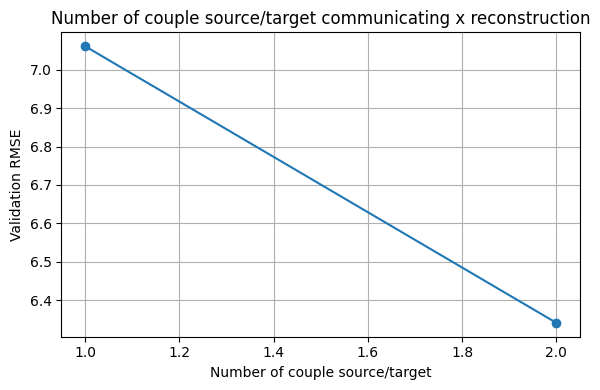

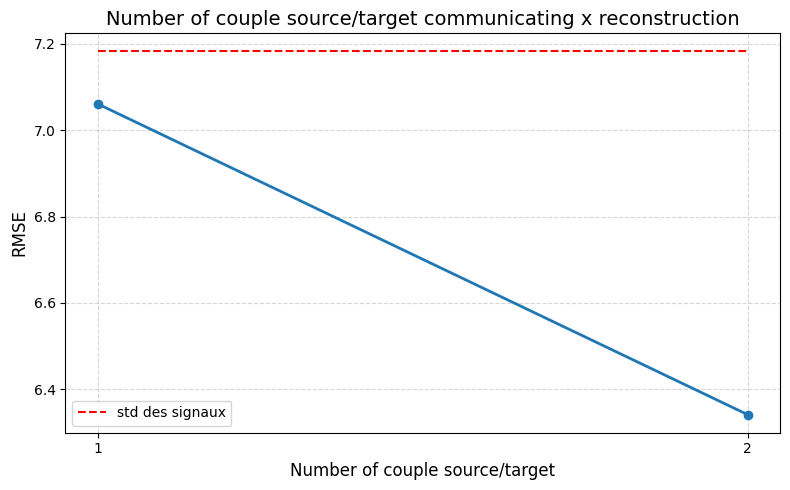

In [30]:
import torch
from torch_geometric.loader import DataLoader

# 1) Define a full‐graph builder
def full_graph_builder(num_nodes, **kwargs):
    # Fully connected (excluding self‐loops—add them back if needed)
    adj = torch.ones((num_nodes, num_nodes))# - torch.eye(num_nodes)
    return adj

# 2) Prepare your experiment specs
experiments = []
for N in range(1, 3):
    # source_nodes = [0,1,...,N−2], target_nodes = [1,2,...,N−1]
    src = list(range(N))
    tgt = [i+1 for i in src]
    experiments.append({
        'num_nodes':    N+1,
        'N' : N,
        'source_nodes': src,
        'target_nodes': tgt,
        'graph_kwargs': {}
    })

# 3) Common builder‐side kwargs
builder_common = {
    'n_signals_per_node': 10000,
    'N':                 200, 
    'encoder_layers':     2,
    'decoder_layers':     2,
    'latent_dim':        64,
    'hidden_dim':        64,
    # 'gat_layers' can come from exp or override here
    'gat_layers':         2,
    'heads':             1,
}

# 4) Model‐side kwargs (disable edge_weight & signed here)
model_common = {
    'use_edge_weight': False,
    'signed':          False
}

# 5) Run all experiments under './model_full'
results = run_experiments(
    experiments          = experiments,
    graph_builder        = full_graph_builder,
    builder_cls          = GraphDatasetBuilder,
    model_cls            = GraphAutoPropagator,
    trainer_cls          = GraphTrainer,
    base_saving_dir      = './model_full',
    train                = True,
    train_params         = {'epochs':3, 'lr':5e-4},
    builder_common_kwargs= builder_common,
    model_common_kwargs  = model_common,
    device               = 'cuda',
    plot                 = True,
    title   = 'Number of couple source/target communicating x reconstruction',
    xlabel = 'Number of couple source/target'
)


### 3.2.2-Number of source target with signed node

adj_matrix tensor([[1., 1.],
        [1., 1.]])


C:\Users\zehav\AppData\Local\Temp\ipykernel_55708\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

📦 Loaded model from ./model_full_signed\exp_N1\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_55708\1750376845.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_nodes = torch.tensor(num_nodes, device=self.device)


📥 New best model (val_loss=3.7949)
📥 New best model (val_loss=3.4578)
📥 New best model (val_loss=3.2874)
[Epoch 3] Train: 3.2853 | Val: 3.2874
📥 New best model (val_loss=3.2397)
📥 New best model (val_loss=3.0877)
📥 New best model (val_loss=2.9418)
[Epoch 6] Train: 2.9238 | Val: 2.9418
📥 New best model (val_loss=2.8804)
📥 New best model (val_loss=2.8179)
📥 New best model (val_loss=2.7464)
[Epoch 9] Train: 2.6733 | Val: 2.7464
📥 New best model (val_loss=2.6233)
📥 New best model (val_loss=2.6017)
📥 New best model (val_loss=2.5519)
[Epoch 12] Train: 2.4583 | Val: 2.5519
📥 New best model (val_loss=2.4216)
📥 New best model (val_loss=2.3505)
📥 New best model (val_loss=2.2087)
[Epoch 15] Train: 2.1496 | Val: 2.2087
📥 New best model (val_loss=2.1842)
📥 New best model (val_loss=2.1477)
📥 New best model (val_loss=2.0929)
[Epoch 18] Train: 1.9998 | Val: 2.0929
📥 New best model (val_loss=1.9863)
📥 New best model (val_loss=1.9390)
📥 New best model (val_loss=1.8669)
[Epoch 21] Train: 1.8066 | Val: 1.

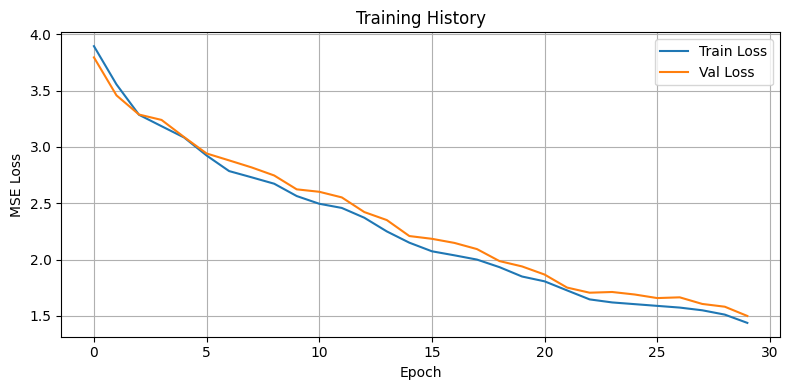

📥 New best model (val_loss=1.4693)
📥 New best model (val_loss=1.4452)
📥 New best model (val_loss=1.4241)
[Epoch 33] Train: 1.3475 | Val: 1.4241
📥 New best model (val_loss=1.3788)
📥 New best model (val_loss=1.3195)
📥 New best model (val_loss=1.2732)
[Epoch 36] Train: 1.2085 | Val: 1.2732
📥 New best model (val_loss=1.2499)
📥 New best model (val_loss=1.2089)
[Epoch 39] Train: 1.1427 | Val: 1.2323
📥 New best model (val_loss=1.1842)
📥 New best model (val_loss=1.1819)
📥 New best model (val_loss=1.1321)
[Epoch 42] Train: 1.0858 | Val: 1.1321
📥 New best model (val_loss=1.0968)
📥 New best model (val_loss=1.0582)
📥 New best model (val_loss=1.0243)
[Epoch 45] Train: 0.9757 | Val: 1.0243
📥 New best model (val_loss=1.0227)
📥 New best model (val_loss=0.9836)
[Epoch 48] Train: 0.9265 | Val: 0.9896
📥 New best model (val_loss=0.9453)
📥 New best model (val_loss=0.8956)


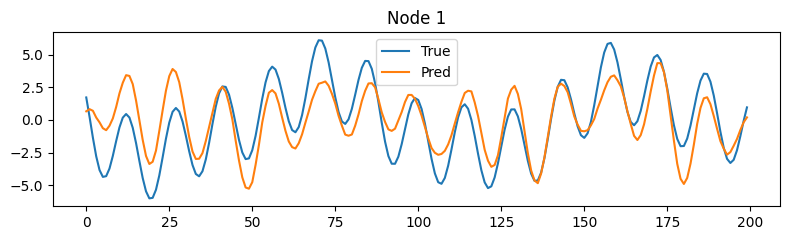

adj_matrix tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


C:\Users\zehav\AppData\Local\Temp\ipykernel_55708\1750376845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

📦 Loaded model from ./model_full_signed\exp_N2\best_model.pt


C:\Users\zehav\AppData\Local\Temp\ipykernel_55708\1750376845.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_nodes = torch.tensor(num_nodes, device=self.device)


📥 New best model (val_loss=3.9501)
📥 New best model (val_loss=3.6289)
📥 New best model (val_loss=3.4337)
[Epoch 3] Train: 3.5924 | Val: 3.4337
📥 New best model (val_loss=3.3658)
📥 New best model (val_loss=3.3117)
📥 New best model (val_loss=3.1069)
[Epoch 6] Train: 3.2238 | Val: 3.1069
📥 New best model (val_loss=2.9095)
📥 New best model (val_loss=2.7746)
📥 New best model (val_loss=2.6404)
[Epoch 9] Train: 2.7175 | Val: 2.6404
📥 New best model (val_loss=2.5933)
📥 New best model (val_loss=2.5863)
📥 New best model (val_loss=2.5698)
[Epoch 12] Train: 2.5529 | Val: 2.5698
📥 New best model (val_loss=2.5485)
📥 New best model (val_loss=2.5135)
📥 New best model (val_loss=2.4144)
[Epoch 15] Train: 2.4265 | Val: 2.4144
📥 New best model (val_loss=2.3794)
📥 New best model (val_loss=2.3766)
📥 New best model (val_loss=2.3597)
[Epoch 18] Train: 2.3232 | Val: 2.3597
📥 New best model (val_loss=2.3094)
📥 New best model (val_loss=2.2012)
[Epoch 21] Train: 2.2057 | Val: 2.2012
📥 New best model (val_loss=2.1

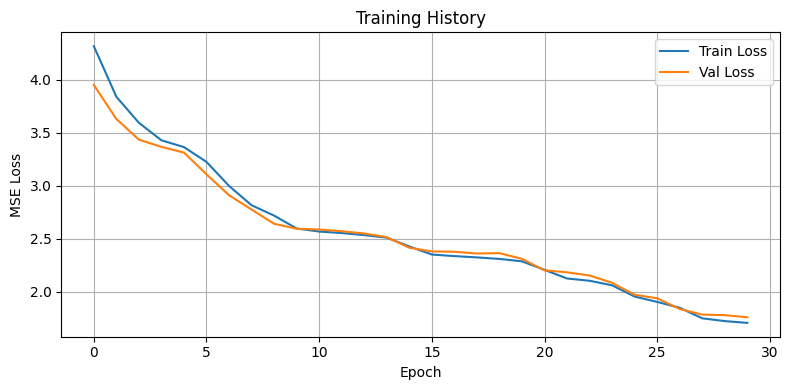

📥 New best model (val_loss=1.7394)
📥 New best model (val_loss=1.7011)
📥 New best model (val_loss=1.5925)
[Epoch 33] Train: 1.5821 | Val: 1.5925
📥 New best model (val_loss=1.5872)
📥 New best model (val_loss=1.5630)
📥 New best model (val_loss=1.5504)
[Epoch 36] Train: 1.4916 | Val: 1.5504
📥 New best model (val_loss=1.5427)
📥 New best model (val_loss=1.5166)
[Epoch 39] Train: 1.4579 | Val: 1.5166
📥 New best model (val_loss=1.4881)
📥 New best model (val_loss=1.4061)
📥 New best model (val_loss=1.3619)
[Epoch 42] Train: 1.3247 | Val: 1.3619
📥 New best model (val_loss=1.3540)
📥 New best model (val_loss=1.3329)
📥 New best model (val_loss=1.3232)
[Epoch 45] Train: 1.2808 | Val: 1.3232
📥 New best model (val_loss=1.2930)
📥 New best model (val_loss=1.2264)
[Epoch 48] Train: 1.2225 | Val: 1.2264
📥 New best model (val_loss=1.1774)


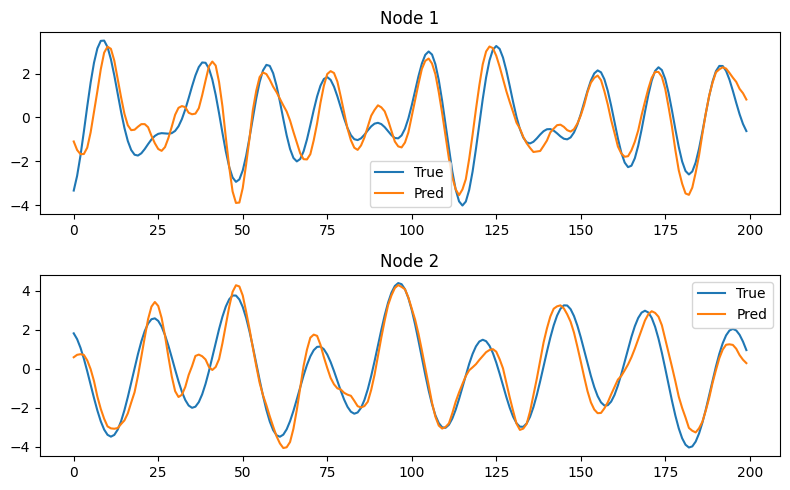

adj_matrix tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


C:\Users\zehav\AppData\Local\Temp\ipykernel_55708\1750376845.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_nodes = torch.tensor(num_nodes, device=self.device)


📥 New best model (val_loss=6.8107)
📥 New best model (val_loss=6.0953)
📥 New best model (val_loss=5.3060)
[Epoch 3] Train: 5.6373 | Val: 5.3060
📥 New best model (val_loss=4.7265)


KeyboardInterrupt: 

In [28]:
import torch
from torch_geometric.loader import DataLoader

# 1) Define a full‐graph builder
def full_graph_builder(num_nodes, **kwargs):
    # Fully connected (excluding self‐loops—add them back if needed)
    adj = torch.ones((num_nodes, num_nodes))# - torch.eye(num_nodes)
    return adj

# 2) Prepare your experiment specs
experiments = []
for N in range(1, 4):
    # source_nodes = [0,1,...,N−2], target_nodes = [1,2,...,N−1]
    src = list(range(N))
    tgt = [i+1 for i in src]
    experiments.append({
        'num_nodes':    N+1,
        'N' : N,
        'source_nodes': src,
        'target_nodes': tgt,
        'graph_kwargs': {}
    })

# 3) Common builder‐side kwargs
builder_common = {
    'n_signals_per_node': 10000,
    'N':                 200, 
    'encoder_layers':     2,
    'decoder_layers':     2,
    'latent_dim':        64,
    'hidden_dim':        64,
    # 'gat_layers' can come from exp or override here
    'gat_layers':         2,
    'heads':             1,
}

# 4) Model‐side kwargs (disable edge_weight & signed here)
model_common = {
    'use_edge_weight': False,
    'signed':          True
}

# 5) Run all experiments under './model_full'
results = run_experiments(
    experiments          = experiments,
    graph_builder        = full_graph_builder,
    builder_cls          = GraphDatasetBuilder,
    model_cls            = GraphAutoPropagator,
    trainer_cls          = GraphTrainer,
    base_saving_dir      = './model_full_signed',
    train                = True,
    train_params         = {'epochs':50, 'lr':5e-4},
    builder_common_kwargs= builder_common,
    model_common_kwargs  = model_common,
    device               = 'cuda',
    plot                 = True,
    title   = 'Number of couple source/target communicating x reconstruction',
    xlabel = 'Number of couple source/target'
)


## 3.3 graph star experiment 

In [35]:
import torch

for i in range(torch.cuda.device_count()):
    props = torch.cuda.get_device_properties(i)
    print(f"GPU {i}: {props.name} - {props.total_memory/1024**3:.1f} GB")


GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU - 8.0 GB


Experiment with ncentre=1, N=11, src=[2, 4, 6, 8, 10], tgt=[1, 3, 5, 7, 9]
Experiment with ncentre=2, N=12, src=[2, 4, 6, 8, 10], tgt=[3, 5, 7, 9, 11]
Experiment with ncentre=3, N=13, src=[4, 6, 8, 10, 12], tgt=[3, 5, 7, 9, 11]
Experiment with ncentre=4, N=14, src=[4, 6, 8, 10, 12], tgt=[5, 7, 9, 11, 13]
Experiment with ncentre=5, N=15, src=[6, 8, 10, 12, 14], tgt=[5, 7, 9, 11, 13]
adj_matrix tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\2592214347.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

📦 Loaded model from ./model_doblestar_signed\exp_N1\best_model.pt


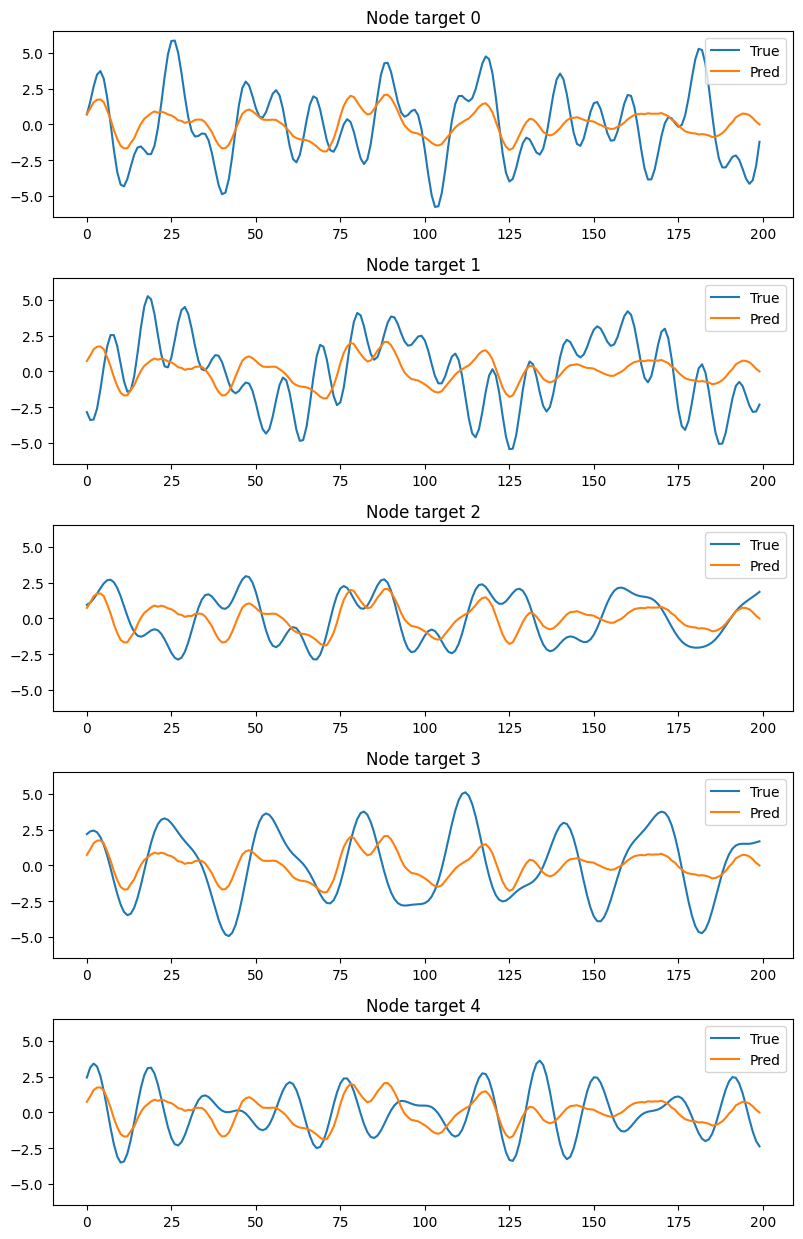

adj_matrix tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\2592214347.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

📦 Loaded model from ./model_doblestar_signed\exp_N2\best_model.pt


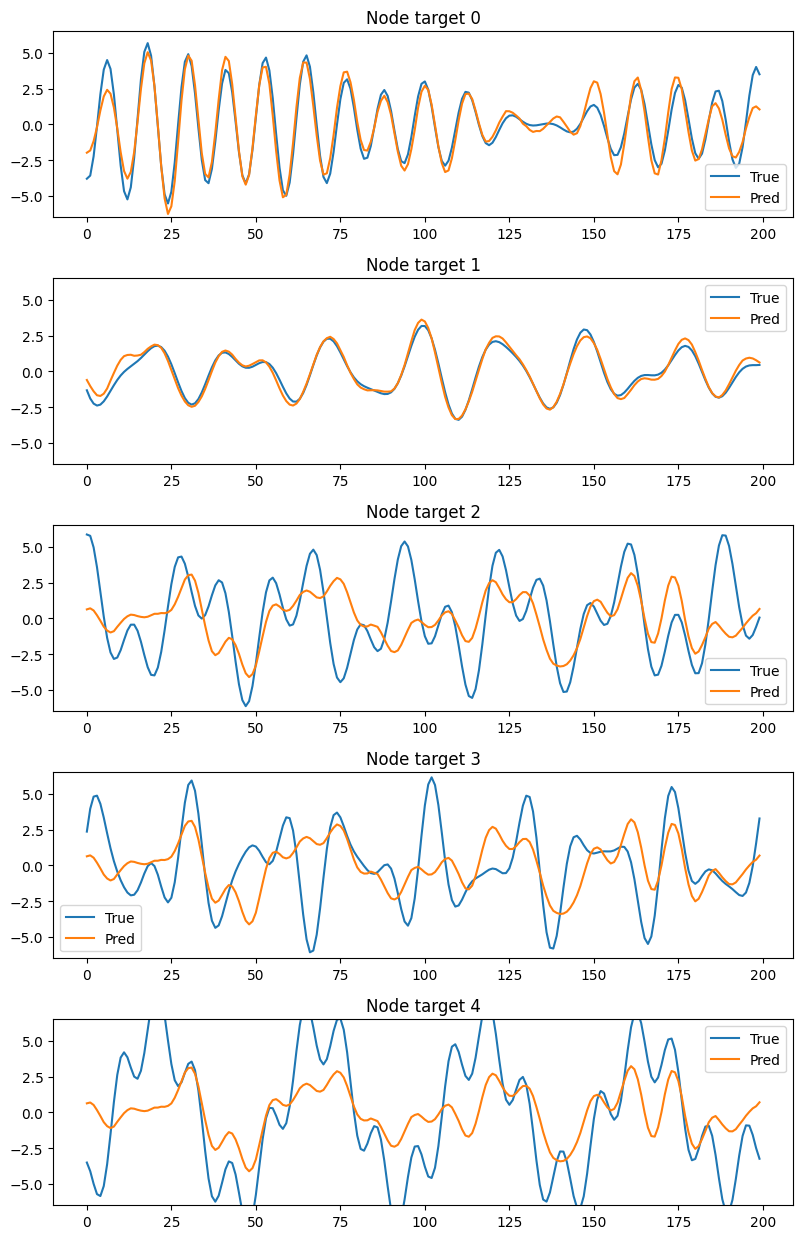

adj_matrix tensor([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\2592214347.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

📦 Loaded model from ./model_doblestar_signed\exp_N3\best_model.pt


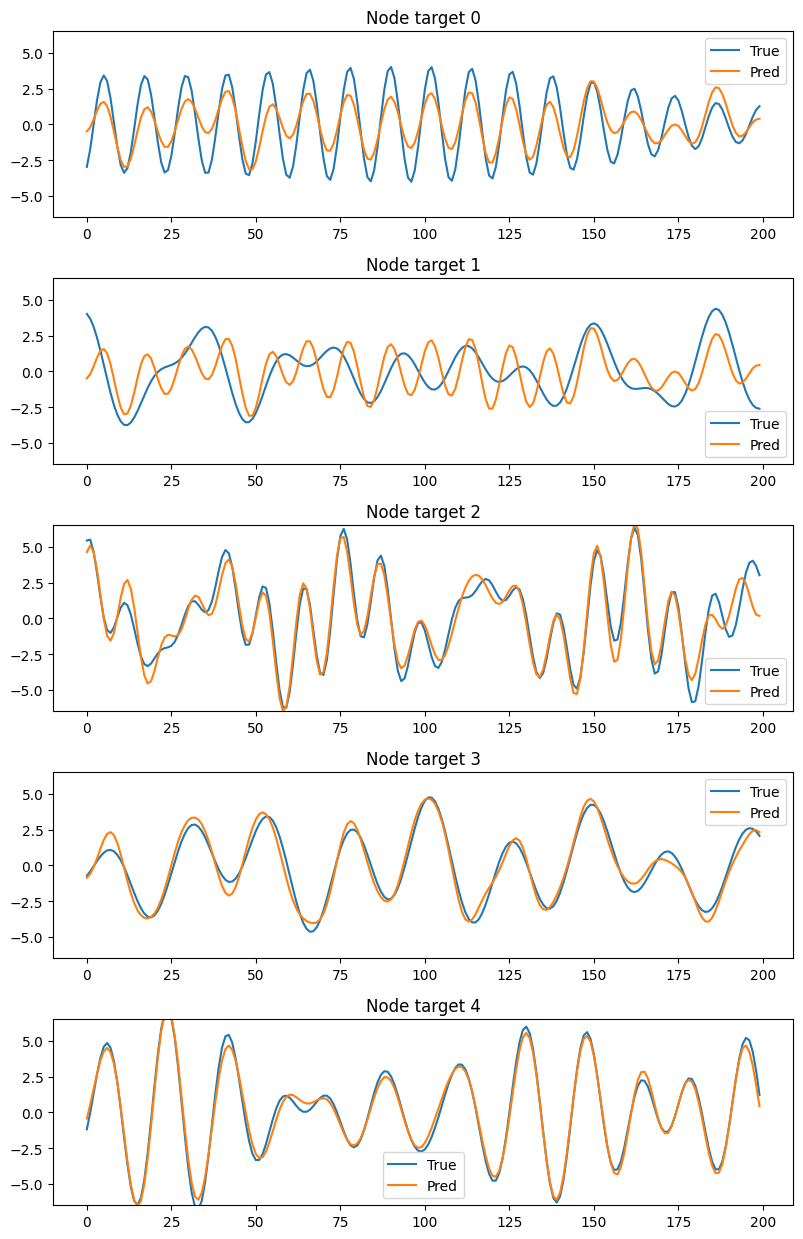

adj_matrix tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\2592214347.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

📦 Loaded model from ./model_doblestar_signed\exp_N4\best_model.pt


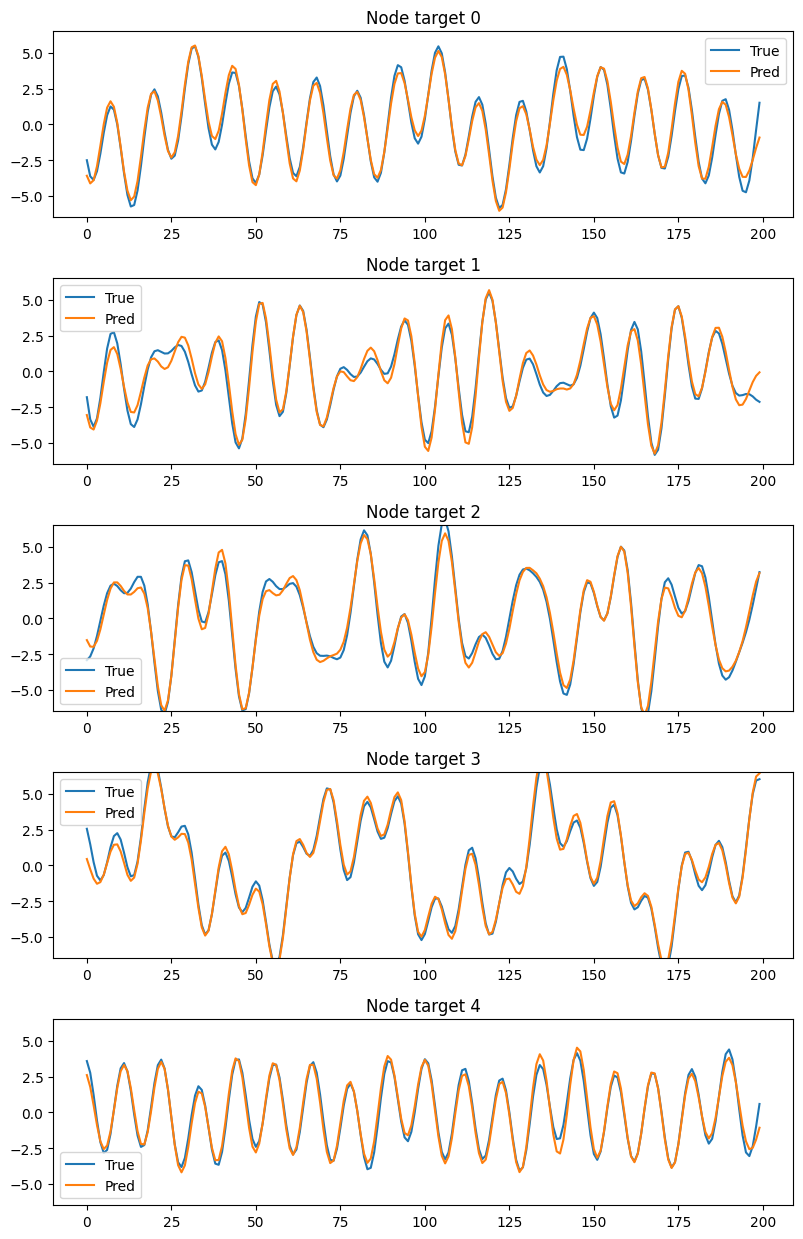

adj_matrix tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [

C:\Users\zehav\AppData\Local\Temp\ipykernel_21132\2592214347.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.model_path, map_

📦 Loaded model from ./model_doblestar_signed\exp_N5\best_model.pt


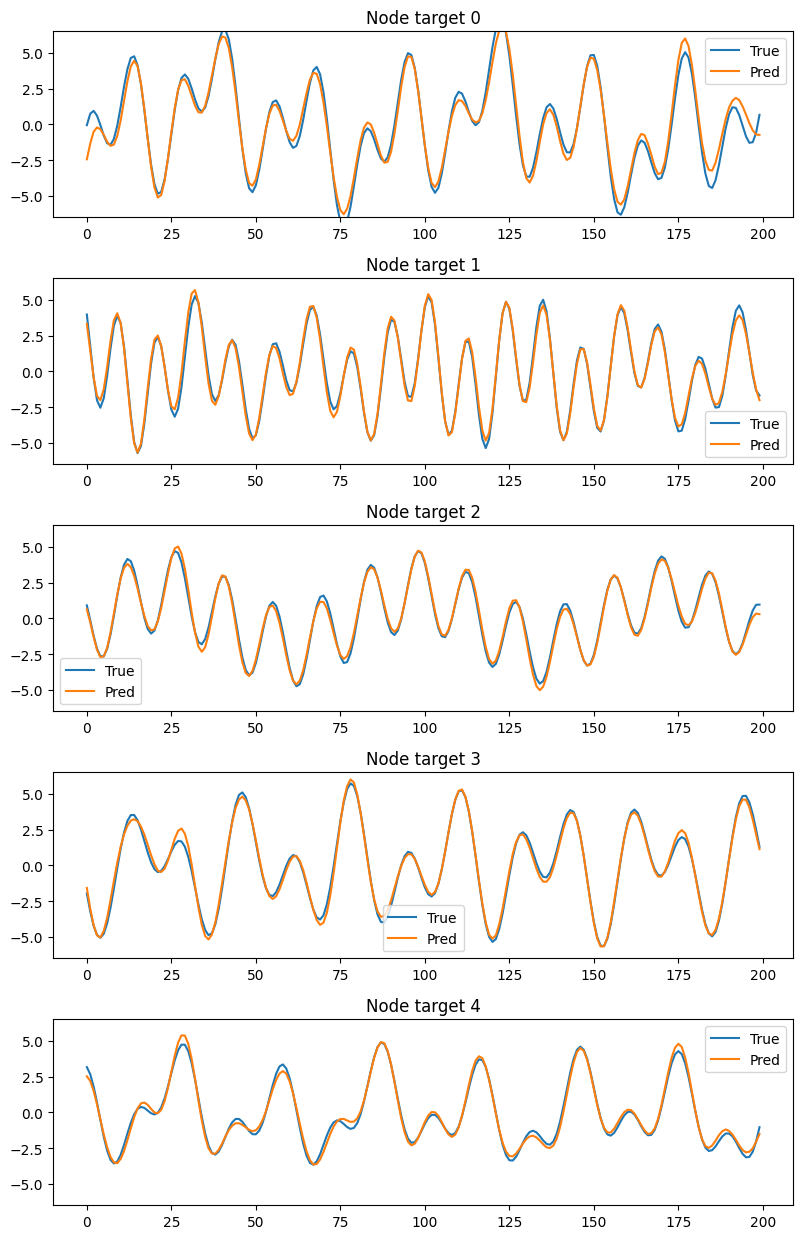

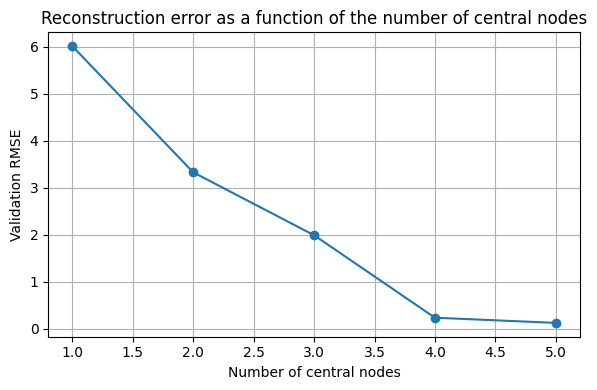

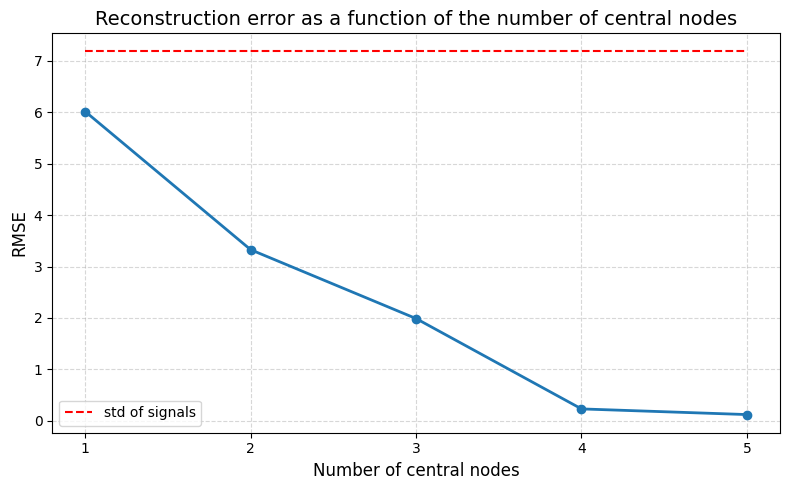

In [47]:
import torch

# 1) Define the double-star signed graph builder
def double_star_signed_builder(num_nodes, **kwargs):
    num_centre = kwargs.get('num_centre', 1)
    adj = torch.zeros((num_nodes, num_nodes))
    # center nodes 0 and 1
    for c in range(num_centre):
        for i in range(num_centre, num_nodes):
            adj[c, i] = 1
    return adj + adj.T

# 2) Prepare experiments
experiments = []
i  = 5
ncenter_start = 1
for ncentre in range(ncenter_start, i+1):
    N = 2*i + ncentre
    src = [j for j in range(ncentre, N) if j%2==0]
    tgt = [j for j in range(ncentre, N) if j%2==1]
    print(f"Experiment with ncentre={ncentre}, N={N}, src={src}, tgt={tgt}")
    experiments.append({
        'num_nodes':    N,
        'N' : ncentre, 
        'source_nodes': src,
        'target_nodes': tgt,
        'graph_kwargs': {'num_centre': ncentre}
    })

# 3) Shared builder kwargs
builder_common = {
    'n_signals_per_node': 10000,
    'N':                 200,
    'encoder_layers':     2,
    'decoder_layers':     2,
    'latent_dim':        64,
    'hidden_dim':        64,
    'gat_layers':         4,   # fixed as in your loop
    'heads':             1
}


# 4) Model‐side kwargs (disable edge_weight & signed here)
model_common = {
    'use_edge_weight': False,
    'signed':          True
}

# 5) Run all experiments under './model_full'
results = run_experiments(
    experiments          = experiments,
    graph_builder        = double_star_signed_builder,
    builder_cls          = GraphDatasetBuilder,
    model_cls            = GraphAutoPropagator,
    trainer_cls          = GraphTrainer,
    base_saving_dir      = './model_doblestar_signed',
    train                = False,
    train_params         = {'epochs':50, 'lr':2e-3, 'batch_size':128},
    builder_common_kwargs= builder_common,
    model_common_kwargs  = model_common,
    device               = 'cuda',
    plot                 = True,
    title   = 'Reconstruction error as a function of the number of central nodes',
    xlabel = 'Number of central nodes'
)
